In [ ]:
from keras.layers import Input,Dense,Flatten
from keras.models import Model

# getting the pretrained model 
from keras.applications.vgg16 import VGG16,preprocess_input  #xception 

from keras.preprocessing import image 
from keras.preprocessing.image import ImageDataGenerator
from keras import utils
from keras.optimizers import Adam

from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from glob import glob

from skimage.transform import resize 

from imageio import imread

In [ ]:
!unzip -n backgrounds.zip

Archive:  backgrounds.zip
   creating: backgrounds/
  inflating: backgrounds/8.jpg       
   creating: __MACOSX/
   creating: __MACOSX/backgrounds/
  inflating: __MACOSX/backgrounds/._8.jpg  
  inflating: backgrounds/9.jpg       
  inflating: __MACOSX/backgrounds/._9.jpg  
  inflating: backgrounds/14.jpg      
  inflating: __MACOSX/backgrounds/._14.jpg  
  inflating: backgrounds/15.jpg      
  inflating: __MACOSX/backgrounds/._15.jpg  
  inflating: backgrounds/12.jpg      
  inflating: __MACOSX/backgrounds/._12.jpg  
  inflating: backgrounds/13.jpg      
  inflating: __MACOSX/backgrounds/._13.jpg  
  inflating: backgrounds/11.jpg      
  inflating: __MACOSX/backgrounds/._11.jpg  
  inflating: backgrounds/10.jpg      
  inflating: __MACOSX/backgrounds/._10.jpg  
  inflating: backgrounds/4.jpg       
  inflating: __MACOSX/backgrounds/._4.jpg  
  inflating: backgrounds/5.jpg       
  inflating: __MACOSX/backgrounds/._5.jpg  
  inflating: backgrounds/7.jpg       
  inflating: __MACOSX/back

In [ ]:
bg_imgs=[]
bg_list=glob('backgrounds/*.jp*g')
for i in bg_list:
  bg=np.array(imread(i))
  bg_imgs.append(bg)

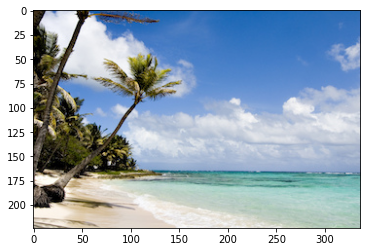

In [ ]:
plt.imshow(bg_imgs[9])

In [ ]:
ch=imread('charmander-tight.png')

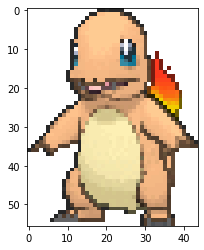

In [ ]:
plt.imshow(ch)

In [ ]:
ch.shape

(56, 44, 4)

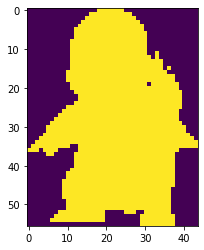

In [ ]:
plt.imshow(ch[:,:,3])
plt.show()

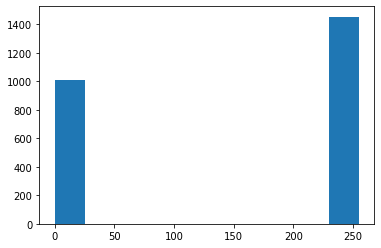

In [ ]:
plt.hist(ch[:,:,3].flatten())
plt.show()

In [ ]:
bla=ch[:,:,3]==0
bla.shape

(56, 44)

In [6]:
a=0

mask=a==0

In [7]:
mask

True

In [ ]:
poke_dim=200
ch=np.array(ch)
ch_h,ch_w,_=ch.shape


def image_generator(batch_size=64):
  while True:
    for _ in range(50):#50 batches per epoch 
      X=np.zeros((batch_size,poke_dim,poke_dim,3))
      Y=np.zeros((batch_size,4))

      for i in range(batch_size):
        #select random bg
        bg_idx=np.random.choice(len(bg_imgs))
        bg=bg_imgs[bg_idx]

        bg_h,bg_w,_=bg.shape

        rnd_h=np.random.randint(bg_h-poke_dim)
        rnd_w=np.random.randint(bg_w-poke_dim)

        X[i]=bg[rnd_h:rnd_h+poke_dim,rnd_w:rnd_w+poke_dim].copy() #bg slice

        #random scaling 
        
        scale=0.5+np.random.random() #0.5,1.5
        
        new_h=int(ch_h*scale)
        new_w=int(ch_w*scale)

        obj=resize(ch,(new_h,new_w),preserve_range=True).astype(np.uint8)

                
        #maybe flip 
        if np.random.random()<0.5:
          obj = np.fliplr(obj)


        row0=np.random.randint(poke_dim-new_h)
        col0=np.random.randint(poke_dim-new_w)
        row1=row0+new_h
        col1=col0+new_w


        mask= obj[:,:,3]==0

        bg_slice=X[i,row0:row1,col0:col1,:] 
        
        bg_slice=np.expand_dims(mask,-1)*bg_slice

        bg_slice=bg_slice+obj[:,:,:3]


        X[i,row0:row1,col0:col1,:]=bg_slice

        Y[i,0]=row0/poke_dim
        Y[i,1]=col0/poke_dim
        Y[i,2]=(row1-row0)/poke_dim
        Y[i,3]=(col1-col0)/poke_dim
      
      yield X/255.,Y



In [ ]:
for x,y in image_generator():
  xx,yy=x,y 
  break

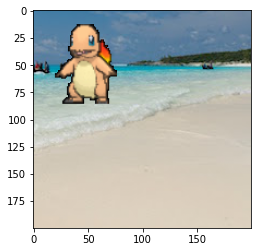

In [ ]:
plt.imshow(xx[1])

In [ ]:
vgg=VGG16(input_shape=[poke_dim,poke_dim,3],weights='imagenet',include_top=False)
x=Flatten()(vgg.output)
x=Dense(4,activation='sigmoid')(x) 

model=Model(vgg.input,x)
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                              

In [ ]:
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.0001))

In [ ]:
hist=model.fit(image_generator(),steps_per_epoch=50,epochs=5,verbose=1)

Epoch 1/5
50/50 [==============================] - 57s 749ms/step - loss: 0.5606
Epoch 2/5
50/50 [==============================] - 37s 744ms/step - loss: 0.5437
Epoch 3/5
50/50 [==============================] - 37s 740ms/step - loss: 0.5439
Epoch 4/5
50/50 [==============================] - 37s 735ms/step - loss: 0.5432
Epoch 5/5
50/50 [==============================] - 37s 737ms/step - loss: 0.5441


In [ ]:
def make_pred():
  #select random bg
  bg_idx=np.random.choice(len(bg_imgs))
  bg=bg_imgs[bg_idx]
  bg_h,bg_w,_=bg.shape

  rnd_h=np.random.randint(bg_h-poke_dim)
  rnd_w=np.random.randint(bg_w-poke_dim)

  x=bg[rnd_h:rnd_h+poke_dim,rnd_w:rnd_w+poke_dim].copy() #bg slice

  #random scaling   
  scale=0.5+np.random.random() #0.5,1.5
  new_h=int(ch_h*scale)
  new_w=int(ch_w*scale)
  obj=resize(ch,(new_h,new_w),preserve_range=True).astype(np.uint8)      
  #maybe flip 
  if np.random.random()<0.5:
    obj = np.fliplr(obj)

  row0=np.random.randint(poke_dim-new_h)
  col0=np.random.randint(poke_dim-new_w)
  row1=row0+new_h
  col1=col0+new_w

  mask=obj[:,:,3]==0
  bg_slice=x[row0:row1,col0:col1,:]
  bg_slice=np.expand_dims(mask,-1)*bg_slice
  bg_slice=bg_slice+obj[:,:,:3]

  x[row0:row1,col0:col1,:]=bg_slice

  print(row0,col0,row1,col1)

  X=np.expand_dims(x,0)/255.
  p=model.predict(X)[0]

  fig,ax=plt.subplots(1)
  ax.imshow(x.astype(np.uint8))
  rect=Rectangle(
      (p[1]*poke_dim,p[0]*poke_dim),
      p[3]*poke_dim,p[2]*poke_dim,
      linewidth=1,
      edgecolor='r',
      facecolor='none'
  )
  ax.add_patch(rect)
  plt.show()



57 59 89 84
1/1 [==============================] - 0s 22ms/step


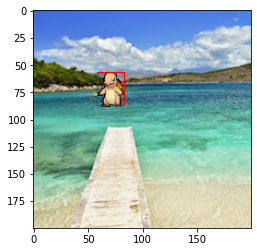

In [ ]:
make_pred()